In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train/255., X_test/255.
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

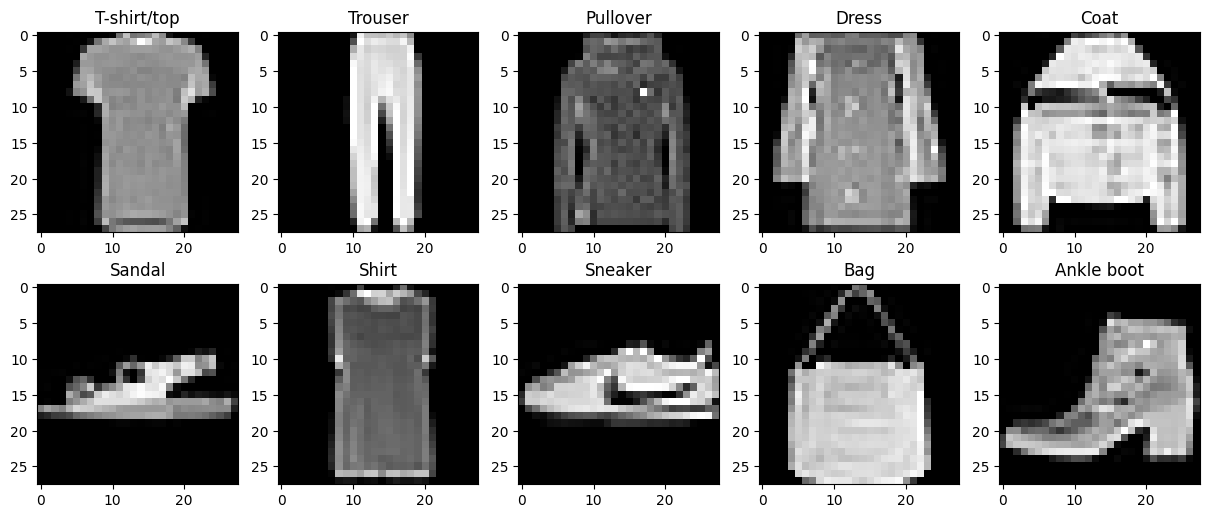

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Trying model on data

In [6]:
from activations import *
from losses import *
from metrics import *
from nn import *
from optimizers import *
from learn import *

In [17]:
model = FeedForwardNeuralNetwork(4, 128, activation='relu', weight_init='random')
optimizer = Adam(model, lr=0.001)
loss_fn = CrossEntropyLoss()
metric = categorical_accuracy

In [18]:
history = fit(
    model,
    X_train[:54000].reshape(-1, 784),
    Y_train[:54000],
    X_train[54000:].reshape(-1, 784),
    Y_train[54000:],
    optimizer,
    loss_fn,
    metric,
    batch_size=128
)

[Epoch 1/10] train loss: 7.042628, val loss:  5.117879 || train score: 0.617634, val score: 0.722167
[Epoch 2/10] train loss: 4.948501, val loss:  5.077281 || train score: 0.731334, val score: 0.724333
[Epoch 3/10] train loss: 4.852755, val loss:  4.876317 || train score: 0.736401, val score: 0.735167
[Epoch 4/10] train loss: 5.425601, val loss:  6.158556 || train score: 0.705299, val score: 0.665500
[Epoch 5/10] train loss: 6.619727, val loss:  7.041978 || train score: 0.640472, val score: 0.617667
[Epoch 6/10] train loss: 8.028004, val loss:  7.814826 || train score: 0.563984, val score: 0.575167
[Epoch 7/10] train loss: 9.390988, val loss:  10.367202 || train score: 0.489908, val score: 0.436833
[Epoch 8/10] train loss: 10.933740, val loss:  10.968212 || train score: 0.406181, val score: 0.404500
[Epoch 9/10] train loss: 11.903517, val loss:  12.587164 || train score: 0.353419, val score: 0.316167
[Epoch 10/10] train loss: 12.253246, val loss:  12.336119 || train score: 0.334586, va

In [13]:
metric(Y_test, predict(model, X_test.reshape(-1, 784)))

0.8441

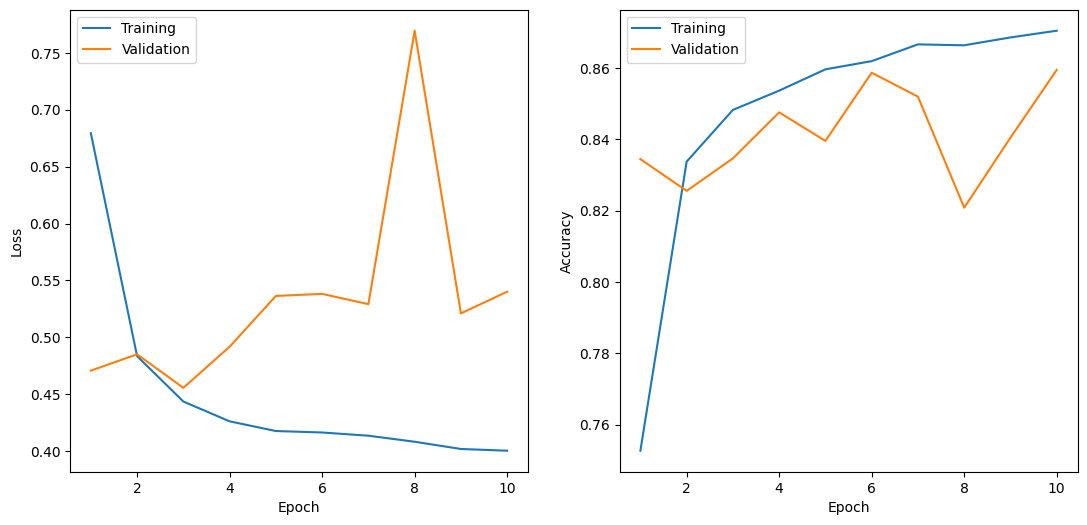

In [14]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.plot(history['epoch'], history['train_loss'], label='Training')
plt.plot(history['epoch'], history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history['epoch'], history['train_score'], label='Training')
plt.plot(history['epoch'], history['val_score'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Hyperparameter tuning

In [30]:
import wandb
from sklearn.model_selection import train_test_split

def perform_run(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        run.name = f'hl_{config.num_layers}_hs_{config.hidden_size}_{config.activation[:4]}_{config.weight_init[:3]}_{config.optimizer}_lr_{config.lr}_wd_{config.weight_decay}_bs_{config.batch_size}'
        X_t, X_v, Y_t, Y_v = train_test_split(X_train.reshape(-1, 784), Y_train, test_size=0.1)
        model = FeedForwardNeuralNetwork(config.num_layers, config.hidden_size, activation=config.activation, weight_init=config.weight_init)
        loss_fn = CrossEntropyLoss()
        if config.optimizer == 'sgd':
            optimizer = StochasticGradientDescent(model, lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == 'momentum':
            optimizer = MomentumGradientDescent(model, lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == 'nag':
            optimizer = NesterovGradientDescent(model, lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == 'rmsprop':
            optimizer = RMSProp(model, lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == 'adam':
            optimizer = Adam(model, lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == 'nadam':
            optimizer = NAdam(model, lr=config.lr, weight_decay=config.weight_decay)
        metric = categorical_accuracy
        history = fit(
            model,
            X_t,
            Y_t,
            X_v,
            Y_v,
            optimizer,
            loss_fn,
            metric,
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=0
        )
        for i in range(len(history['epoch'])):
            wandb.log({'epoch': history['epoch'][i], 'loss': history['train_loss'][i], 'accuracy': history['train_score'][i], 'val_loss': history['val_loss'][i], 'val_accuracy': history['val_score'][i]})

In [ ]:
import datetime as dt

sweep_config = {
    'method': 'random',
    'name' : str(dt.datetime.now().strftime("%d-%m-%y_%H:%M"))
}
sweep_metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'
}
sweep_config['metric'] = sweep_metric
parameters = {
    'num_layers': {
        'values': [1, 2, 3, 4]
    },
    'hidden_size': {
        'values': [16, 32, 64, 128]
    },
    'activation': {
        'values': ['sigmoid', 'tanh', 'relu']
    },
    'weight_init': {
        'values': ['random', 'xavier']
    },
    'optimizer': {
        'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
    },
    'lr': {
        'values': [1e-1, 1e-2, 1e-3, 1e-4]
    },
    'weight_decay': {
        'values': [0.0, 1e-1, 1e-2, 1e-3]
    },
    'batch_size': {
        'values': [16, 32, 64, 128]
    }
}
sweep_config['parameters'] = parameters
parameters.update({
    'epochs': {
        'value': 10
    }
})
sweep_id = wandb.sweep(sweep_config, project='CS6910-A1')

wandb.agent(sweep_id, perform_run, count=500)